In [1]:
from torchvision.datasets import STL10
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torch
from torchvision import models
import pandas as pd
from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss
import numpy as np
from torchvision import transforms
import os

In [2]:
class ReconstructionDataModule(pl.LightningDataModule):
    def __init__(self, path, preprocess, batch_size=32):
        super().__init__()
        self.path = path
        self.batch_size = batch_size
        self.preprocess = preprocess

    def setup(self, stage=None):
        dataset = STL10(self.path, split="unlabeled", transform=self.preprocess, download=True)
        self.train_dataset, self.val_dataset = random_split(dataset, [.8, .2])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

In [3]:
def read_csv(path):
    files = os.listdir(path)
    dfs = {}
    for file in files:
        if file.endswith(".csv"):
            dfs[file] = pd.read_csv(os.path.join(path, file), sep=",")
    return dfs

In [7]:
dfs = read_csv("../scripts/lightning_logs/checkpoints-pretrained-bigan-linear-eval/")

In [47]:
def plot_loss(dfs):
    plt.figure(figsize=(15, 10))
    epochs = np.arange(1, len(dfs["train_loss_eval.csv"]["Value"]) + 1)
    plt.plot(epochs, dfs["train_loss_eval.csv"]["Value"], label="Train loss")
    plt.plot(epochs, dfs["val_loss_eval.csv"]["Value"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.ylim(1.75, 2.4)
    plt.title("Loss curve - BiGAN")
    plt.legend()
    plt.show()
    
def plot_accuracy(dfs):
    plt.figure(figsize=(15, 10))
    epochs = np.arange(1, len(dfs["train_accuracy_eval.csv"]["Value"]) + 1)
    plt.plot(epochs, dfs["train_accuracy_eval.csv"]["Value"], label="Train accuracy")
    plt.plot(epochs, dfs["val_accuracy_eval.csv"]["Value"], label="Val accuracy")
    plt.grid()
    plt.ylabel("Accuracy")
    plt.title("Accuracy curve - BiGAN")
    plt.legend()
    plt.show()

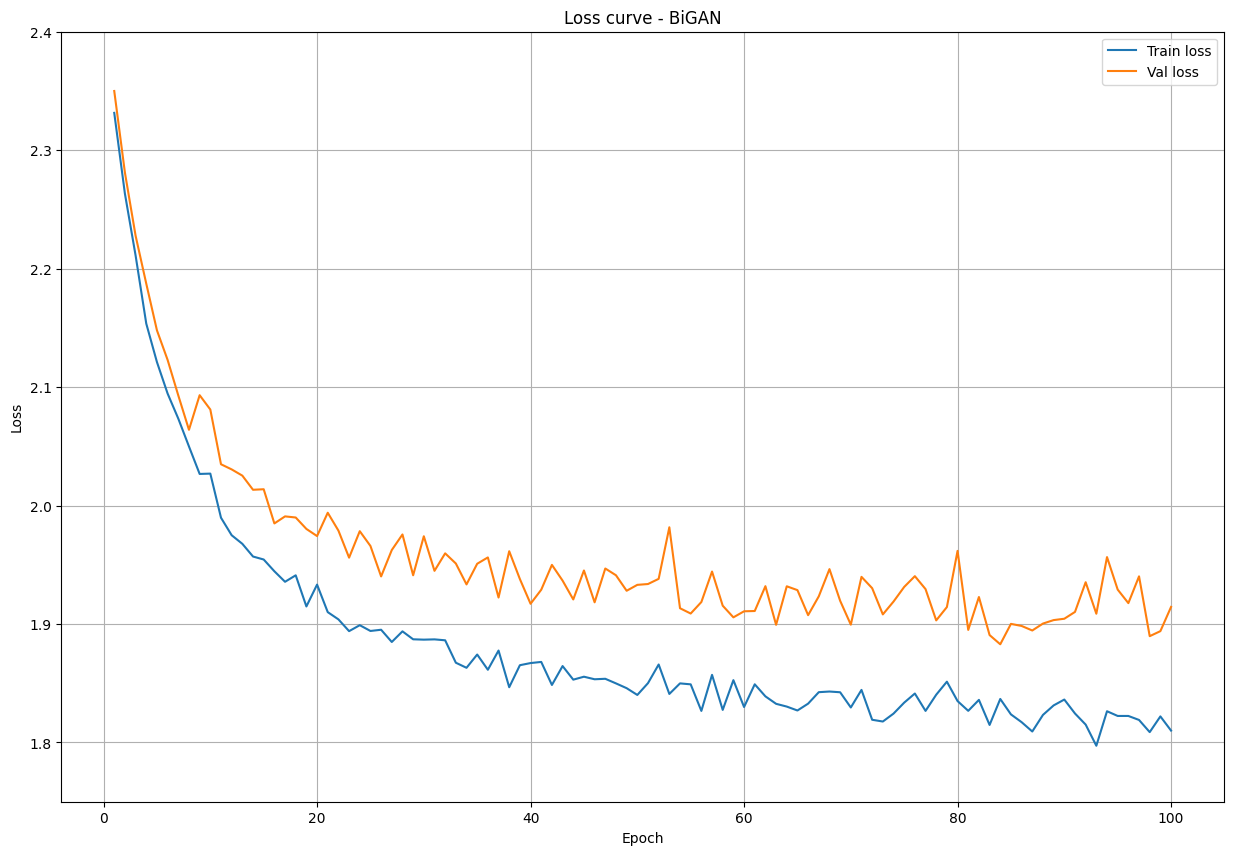

In [48]:
plot_loss(dfs)

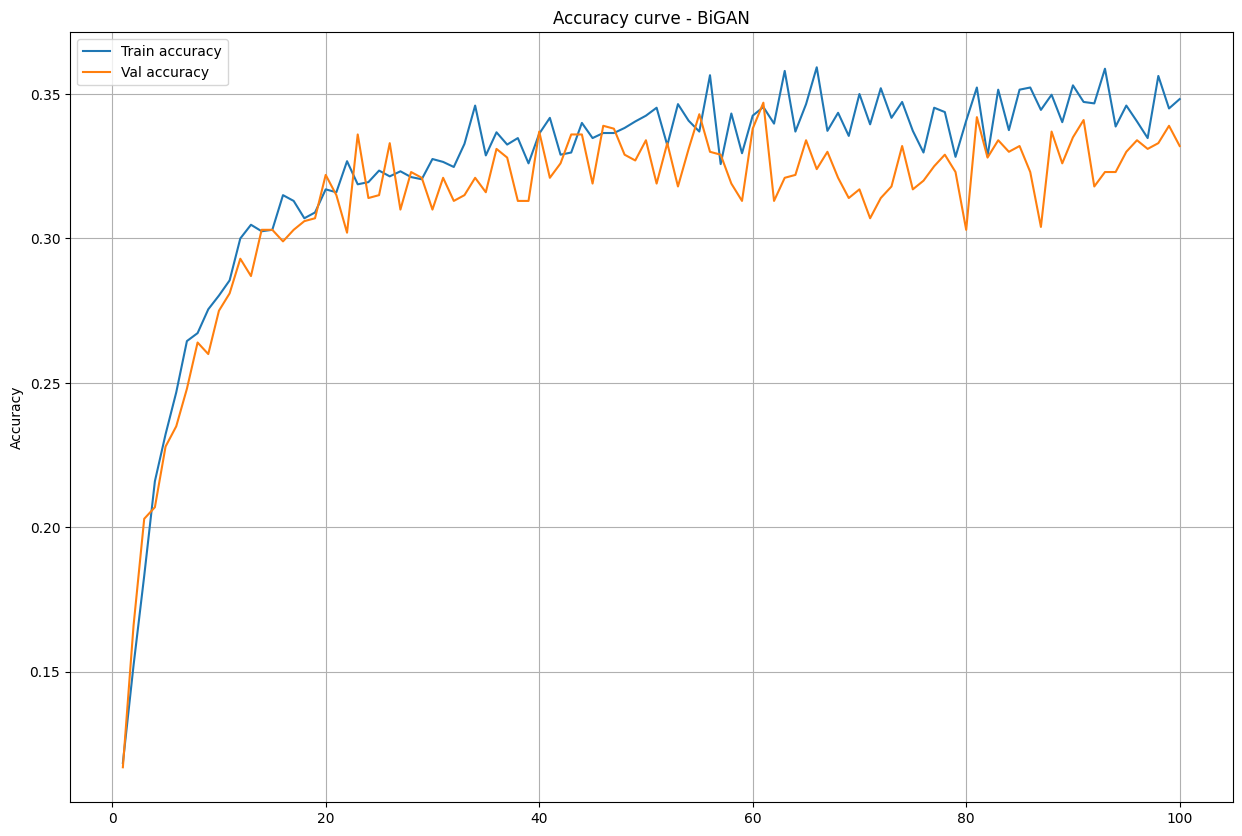

In [49]:
plot_accuracy(dfs)

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class ResNet18Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_channels = 512
        self.conv1 = nn.ConvTranspose2d(64, 3, kernel_size=7, stride=2, padding=3, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

        self.layer4 = self._make_layer(512, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer1 = self._make_layer(64, 2, stride=1)

        self.linear = nn.Linear(64, 4608)


    def _make_layer(self, out_channels, blocks, stride):
        upsample = None
        if stride != 1 or self.in_channels != out_channels * BasicDecoderBlock.expansion:
            upsample = nn.Sequential(
                nn.ConvTranspose2d(self.in_channels, out_channels * BasicDecoderBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicDecoderBlock.expansion),
            )

        layers = []
        layers.append(BasicDecoderBlock(self.in_channels, out_channels, stride, upsample))
        self.in_channels = out_channels * BasicDecoderBlock.expansion
        for _ in range(1, blocks):
            layers.append(BasicDecoderBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, z):
        z = self.linear(z)

        x = z.reshape(-1, 512, 3, 3)

        x = self.layer4(x)
        x = F.interpolate(x, size=(6, 6))
        x = self.layer3(x)
        x = F.interpolate(x, size=(12, 12))
        x = self.layer2(x)
        x = F.interpolate(x, size=(24, 24))
        x = self.layer1(x)

        x = self.relu(x)
        x = self.upsample(x)
        x = self.bn1(x)

        x = self.conv1(x)
        x = F.interpolate(x, size=(96, 96))
        return x


class BasicDecoderBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [8]:
import torch.nn as nn


class BasicEncoderBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet18Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(4608, 64)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * BasicEncoderBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * BasicEncoderBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicEncoderBlock.expansion),
            )

        layers = []
        layers.append(BasicEncoderBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * BasicEncoderBlock.expansion
        for _ in range(1, blocks):
            layers.append(BasicEncoderBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        n, _, _, _, = x.shape
        z = x.reshape(n, -1)
        z = self.linear(z)
        return z


In [15]:
def adversarial_loss(y_hat, y):
    return bce_loss(y_hat, y)

class Discriminator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + int(np.prod(img_shape)), 1024),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, z, img):
        img_flat = img.view(img.size(0), -1)
        d_in = torch.cat((z, img_flat), dim=1)
        validity = self.model(d_in)
        return validity


def replace_last_resnet_linear_layer():
    resnet = models.resnet18(pretrained=True)
    resnet.fc = nn.Linear(512, 64)
    return resnet


class BiGAN(pl.LightningModule):
    def __init__(self, latent_dim=64, lr=0.001, b1=0.5, b2=0.999):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        # self.encoder = ResNet18Encoder()
        self.encoder = replace_last_resnet_linear_layer()
        self.decoder = ResNet18Decoder()
        self.discriminator = Discriminator(latent_dim, (3, 96, 96))
        self.latent_dim = latent_dim

    def forward(self, x):
        z = self.encoder(x)
        img = self.decoder(z)
        return img

    def training_step(self, batch, batch_idx):
        (opt_g, opt_d) = self.optimizers()
        imgs, _ = batch

        z = self.encoder(imgs)

        gen_imgs = self.decoder(z)

        validity_real = self.discriminator(z, imgs)
        validity_fake = self.discriminator(z, gen_imgs)

        g_loss = adversarial_loss(validity_fake, torch.ones_like(validity_fake))

        real_loss = adversarial_loss(validity_real, torch.ones_like(validity_real))
        fake_loss = adversarial_loss(validity_fake, torch.zeros_like(validity_fake))
        d_loss = (real_loss + fake_loss) / 2

        opt_d.zero_grad()
        opt_g.zero_grad()

        d_loss.backward(retain_graph=True)
        g_loss.backward()

        opt_d.step()
        opt_g.step()

        self.log('train_d_loss', d_loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)
        self.log('train_g_loss', g_loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)
        return {"d_loss": d_loss, "g_loss": g_loss}
    
    def validation_step(self, batch, batch_idx):
        imgs, _ = batch

        z = self.encoder(imgs)

        gen_imgs = self.decoder(z)

        validity_real = self.discriminator(z, imgs)
        validity_fake = self.discriminator(z, gen_imgs)

        g_loss = adversarial_loss(validity_fake, torch.ones_like(validity_fake))
        
        real_loss = adversarial_loss(validity_real, torch.ones_like(validity_real))
        fake_loss = adversarial_loss(validity_fake, torch.zeros_like(validity_fake))
        d_loss = (real_loss + fake_loss) / 2

        self.log('val_d_loss', d_loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)
        self.log('val_g_loss', g_loss, prog_bar=True, on_step=False, on_epoch=True, logger=True)
        return {"val_d_loss": d_loss, "val_g_loss": g_loss}

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2
        opt_g = torch.optim.Adam(self.decoder.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

In [10]:
data = ReconstructionDataModule("../data/bigan", transforms.Compose([transforms.ToTensor()]))

In [ ]:
trainer = pl.Trainer(max_epochs=1)
# trainer.fit(BiGAN(), data)